In [1]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, Flatten, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import os


In [2]:
real = "real_and_fake_face_detection/real_and_fake_face/training_real/"
fake = "real_and_fake_face_detection/real_and_fake_face/training_fake/"

# Load image paths
real_path = os.listdir(real)
fake_path = os.listdir(fake)

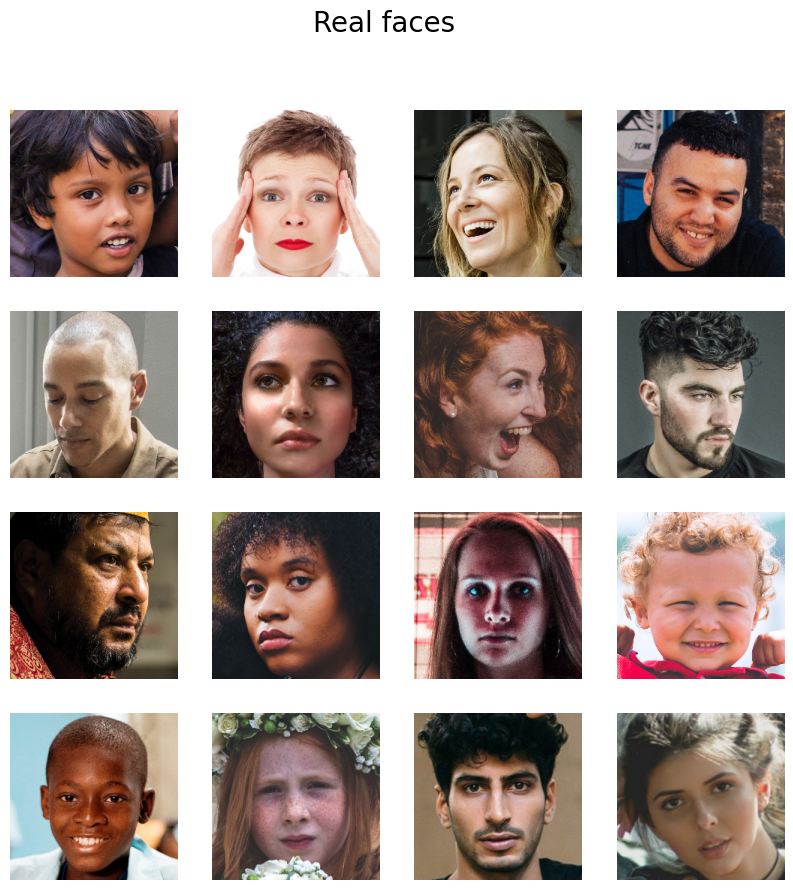

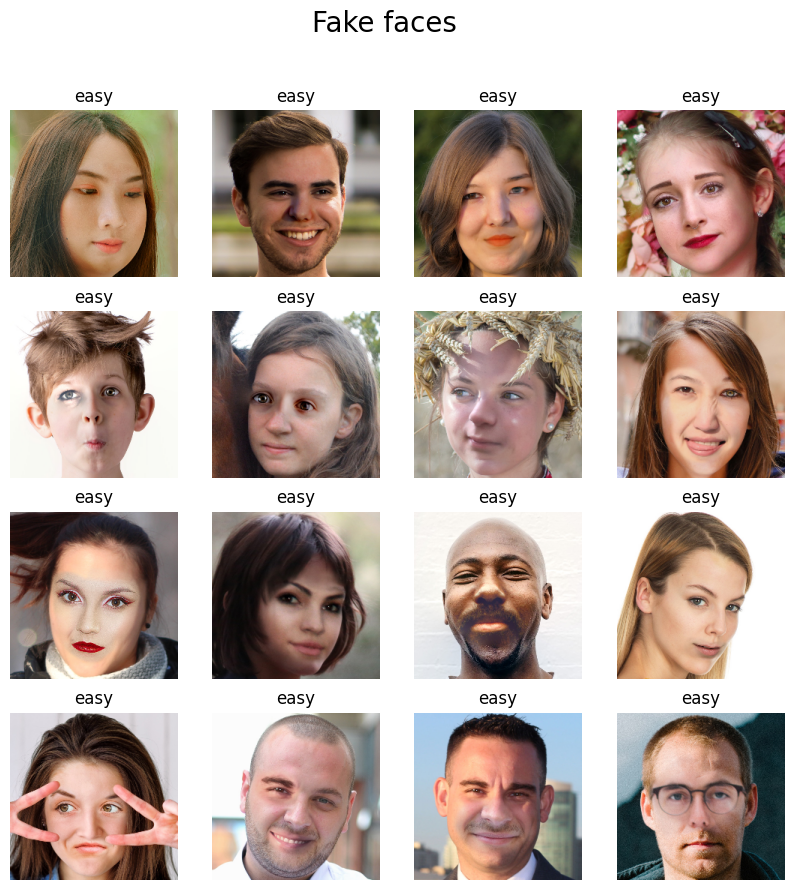

In [3]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    return image[..., ::-1]

fig = plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces", fontsize=20)
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fake faces", fontsize=20)
    plt.title(fake_path[i][:4])
    plt.axis('off')
plt.show()


In [4]:
dataset_path = "real_and_fake_face"
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                   validation_split=0.2)
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="training")
val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="validation")


Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [5]:
mnet = MobileNetV2(include_top=False, weights="imagenet", input_shape=(96, 96, 3))
tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation="relu"),
                    Dropout(0.1),
                    Dense(2, activation="softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [6]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)
hist = model.fit(train,
                 epochs=20,
                 callbacks=[lr_callbacks],
                 validation_data=val)

Epoch 1/20
52/52 [==============================] - 220s 3s/step - loss: 0.8767 - accuracy: 0.6087 - val_loss: 0.8267 - val_accuracy: 0.5368 - lr: 0.0010
Epoch 2/20
52/52 [==============================] - 55s 1s/step - loss: 0.5665 - accuracy: 0.7165 - val_loss: 1.0544 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
52/52 [==============================] - 58s 1s/step - loss: 0.4817 - accuracy: 0.7667 - val_loss: 1.1831 - val_accuracy: 0.4951 - lr: 0.0010
Epoch 4/20
52/52 [==============================] - 59s 1s/step - loss: 0.3631 - accuracy: 0.8475 - val_loss: 0.9853 - val_accuracy: 0.5074 - lr: 1.0000e-04
Epoch 5/20
52/52 [==============================] - 60s 1s/step - loss: 0.3333 - accuracy: 0.8598 - val_loss: 1.0066 - val_accuracy: 0.4951 - lr: 1.0000e-04
Epoch 6/20
52/52 [==============================] - 59s 1s/step - loss: 0.3228 - accuracy: 0.8683 - val_loss: 1.0180 - val_accuracy: 0.4975 - lr: 1.0000e-04
Epoch 7/20
52/52 [==============================] - 64s 1s/step - los

In [7]:
model.save('deepfakedetection_model.h5')

In [9]:
# After creating train generator
print(train.class_indices)


{'training_fake': 0, 'training_real': 1}


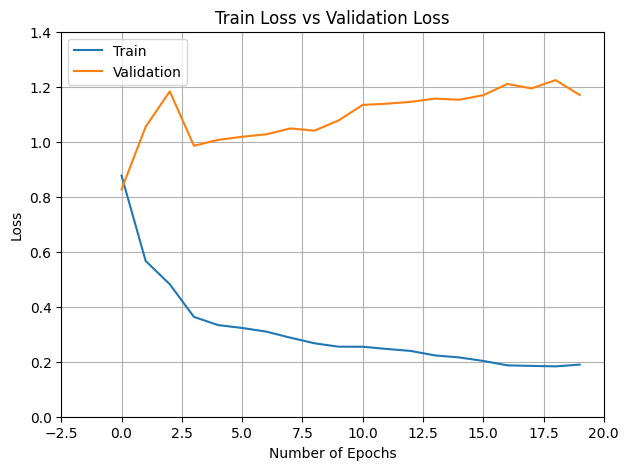

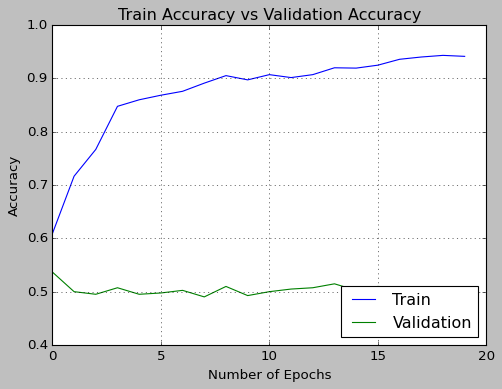

In [8]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1, figsize=(7, 5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.grid(True)
plt.legend(['Train', 'Validation'])
plt.style.use(['classic'])

plt.figure(2, figsize=(7, 5))
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Validation Accuracy')
plt.grid(True)
plt.legend(['Train', 'Validation'], loc=4)
plt.style.use(['classic'])
plt.show()

In [12]:
import numpy as np
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array


In [13]:
model = load_model('deepfake_detection_model.h5')

In [14]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (96, 96))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    return image


In [16]:
class_indices = {'training_fake': 0, 'training_real': 1}
inv_class_indices = {v: k for k, v in class_indices.items()}

def predict_image(image_path):
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    class_label = np.argmax(prediction, axis=1)[0]
    
    predicted_class = inv_class_indices[class_label]
    
    if 'fake' in predicted_class:
        return "Fake"
    else:
        return "Real"
# Example usage
image_path = "real_and_fake_face_detection/real_and_fake_face/training_fake/easy_6_1110.jpg"
result = predict_image(image_path)
print(f"The image is {result}")

The image is Fake
